# Реализация сети U-Net

In [44]:
import numpy as np
import pylab

import torch
import torch.nn as nn

from torchviz import make_dot

In [13]:
dir = "./"
npfile = np.load(dir + "data-airfoils.npz")

print(f"Обучающих примеров (inputs): {len(npfile['inputs'])}, тестовых примеров: {len(npfile['vinputs'])}") 
print(f"Обучающих примеров (targets): {len(npfile['targets'])}") 
print(f"Размер тензора inputs: {npfile['inputs'].shape}") 
print(f"Размер тензора targets: {npfile['targets'].shape}")

Обучающих примеров (inputs): 320, тестовых примеров: 80
Обучающих примеров (targets): 320
Размер тензора inputs: (320, 3, 128, 128)
Размер тензора targets: (320, 3, 128, 128)


Статистика 0: [-0.3255776199086798, 0.23393399824079095, 0.47048169549735686]
Статистика 1: [-0.6548143700240462, 0.017164150495987723, 0.8552243695079386]
Статистика 2: [-0.5325950274411584, -0.04987998400700594, 1.0]


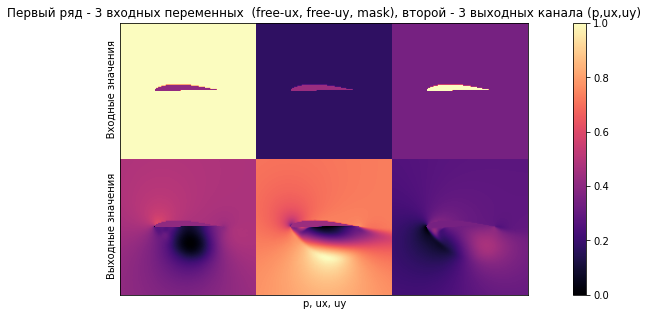

In [23]:
import pylab

def showSbs(a1, a2, stats=False, bottom="NN Output", top="Reference", title=None): 
    c = []
    for i in range(3):
        b = np.flipud(np.concatenate((a2[i], a1[i]), axis=1).transpose())
        min, mean, max = np.min(b), np.mean(b), np.max(b); 
        if stats: 
            print("Статистика %d: "%i + format([min, mean, max]))
        
        b -= min; 
        b /= (max-min)
        c.append(b)
    
    fig, axes = pylab.subplots(1, 1, figsize=(16, 5))
    axes.set_xticks([]); 
    axes.set_yticks([]); 
    im = axes.imshow(np.concatenate(c, axis=1), origin='upper', cmap='magma')

    pylab.colorbar(im); 
    pylab.xlabel('p, ux, uy'); 
    pylab.ylabel('%s           %s'%(bottom,top))
    if title is not None: pylab.title(title)

NUM = 72
showSbs(npfile["inputs"][NUM], npfile["targets"][NUM], 
        stats=True, 
        bottom="Выходные значения", 
        top="Входные значения", 
        title="Первый ряд - 3 входных переменных  (free-ux, free-uy, mask), второй - 3 выходных канала (p,ux,uy)")


In [28]:
BATCH_SIZE = 10

In [32]:
class Dataset():
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets
        
    def __len__(self):
        return len(self.inputs) 
    
    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]
    
tdata = Dataset(npfile['inputs'], npfile['targets'])
vdata = Dataset(npfile['vinputs'], npfile['vtargets'])

train_loader = torch.utils.data.DataLoader(tdata, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(vdata, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

print(f"Тестовых и валидационных батчей: {len(train_loader)} , {len(val_loader)}")

Тестовых и валидационных батчей: 32 , 8


### Архитектура нейросети

In [70]:
def get_block(in_channels, out_channels, name="layer", size=4, pad=1):
    block = nn.Sequential()
    
    block.add_module('%s_conv' % name, nn.Conv2d(in_channels, out_channels, 
                                                 kernel_size=size, stride=2, padding=pad, bias=True))
    block.add_module('%s_relu' % name, nn.ReLU(inplace=True))
    
    return block

In [71]:
class PNet(nn.Module):
    def __init__(self, channelExponent=6):
        super().__init__()
        
        channels = int(2 ** channelExponent + 0.5)
        self.layer1 = get_block(3, channels*1)
        
    def forward(self, x):
        out1 = self.layer1(x)
        
        return out1

In [73]:
EXPO = 3

model = PNet(EXPO)
x = tdata[0]
y = model(x)

for i, traindata in enumerate(train_loader, 0):
    inputs_curr, targets_curr = traindata
    inputs.data.copy_(inputs_curr.float())
    targets.data.copy_(targets_curr.float())
    gen_out = model(inputs)
    break 
    
# print(model)
# make_dot(y, params=dict(model.named_parameters()))

TypeError: conv2d() received an invalid combination of arguments - got (tuple, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!tuple of (numpy.ndarray, numpy.ndarray)!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!tuple of (numpy.ndarray, numpy.ndarray)!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)


In [ ]:
make_dot(y.mean(), params=dict(model.named_parameters()))